# Predicting English tense from context

## Table of Contents

##### I. <a href=#I>Preliminary steps</a>
##### II. <a href=#II>Prepare the data</a>
##### III. <a href=#III>Feed-forward neural network model</a>
##### IV. <a href=#IV>Long short-term memory model</a>
##### V. <a href=#V>Naive discriminative learning model</a>

## I. Preliminary steps <a ID="I"></a> 

### Import necessary libraries and set up the working directory

In [3]:
### Import necessary packages
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy
from keras import metrics
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import talos as ta

### Set working directory
TOP = '/media/Deep_text_modelling_package_repo/'
WD = TOP + 'package'
os.chdir(WD)

### Import local packages
import deep_text_modelling.preprocessing as pr
import deep_text_modelling.modelling as md
import deep_text_modelling.evaluation as ev

# Display option for dataframes and matplotlib
pd.set_option('display.max_colwidth', 100) # Max width of columns when dispalying datasets
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
%matplotlib inline

In [ ]:
import imp
imp.reload(pr)
imp.reload(md)
imp.reload(ev)

### Define file paths

In [43]:
TENSES_FULL_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_full.csv"
TENSES_TRAIN_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_train.csv"
TENSES_VALID_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_valid.csv"
TENSES_TEST_CSV = TOP + "illustrative_examples/tenses/Data/Tenses_test.csv"
CUE_INDEX = TOP + "illustrative_examples/tenses/Data/Cue_index.csv"
OUTCOME_INDEX = TOP + "illustrative_examples/tenses/Data/Outcome_index.csv"
TEMP_DIR = TOP + "illustrative_examples/tenses/Data/"

### Parameters to use

In [5]:
N_outcomes = 3 # number of most frequent outcomes to keep 
N_cues = 2000  # number of cues to keep (all alphabet letters)
max_len = 20 # consider only the first 'max_len' cues in a sequence when applying LSTM (11 is the longest name in the dataset)
no_threads = 16 # Number of CPU cores to use
prop_valid = 1/10 # proportion of validation data
prop_test = 1/10 # proportion of test data

## II. Prepare the data <a name="II"></a> 

### Load the data

In [8]:
tenses_full = pd.read_csv(TENSES_FULL_CSV)
print(f'Number of examples: {len(tenses_full)}')
tenses_full.head(5)

Number of examples: 30000


,sentences,verb_forms,tenses,cues,outcomes
0,gifts of bulbs and trees will be much appreciated in the period september to december,will be appreciated,FutureSimple,gifts_of_bulbs_and_trees_much_in_the_period_september_to_december,FutureSimple
1,i will pick them up then,will pick,FutureSimple,i_them_up_then,FutureSimple
2,the shelters housing each flight will protect the equipment against a surprise attack by soviet ...,will protect,FutureSimple,the_shelters_housing_each_flight_the_equipment_against_a_surprise_attack_by_soviet_aircraft_or_m...,FutureSimple
3,what sort of shops will sell the product,will sell,FutureSimple,what_sort_of_shops_the_product,FutureSimple
4,but he was angry,was,PastSimple,but_he_angry,PastSimple


In [7]:
# Retain only the 'cues' and 'outcomes' columns
tenses_full = tenses_full[['cues', 'outcomes']]
tenses_full.head(5)

,cues,outcomes
0,gifts_of_bulbs_and_trees_much_in_the_period_september_to_december,FutureSimple
1,i_them_up_then,FutureSimple
2,the_shelters_housing_each_flight_the_equipment_against_a_surprise_attack_by_soviet_aircraft_or_m...,FutureSimple
3,what_sort_of_shops_the_product,FutureSimple
4,but_he_angry,PastSimple


### Create index systems for the cues and outcomes

In [14]:
# Create the files containing the index systems
pr.create_index_systems_from_df(data = tenses_full, 
                                cue_index_path = CUE_INDEX, 
                                outcome_index_path = OUTCOME_INDEX)

In [7]:
# Import the cue index system
cue_to_index = pr.import_index_system(CUE_INDEX, N_tokens = N_cues)
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{the: 1}
{of: 2}
{and: 3}
{a: 4}
{in: 5}


In [8]:
# Import the outcome index system
outcome_to_index = pr.import_index_system(OUTCOME_INDEX)
outcome_to_index

{'FutureSimple': 1, 'PastSimple': 2, 'PresentSimple': 3}

In [18]:
# Reverse the cue dictionary
index_to_cue = pr.reverse_dictionary(cue_to_index)
# Reverse the outcome dictionary
index_to_outcome = pr.reverse_dictionary(outcome_to_index)
index_to_outcome

{1: 'FutureSimple', 2: 'PastSimple', 3: 'PresentSimple'}

### Split into training, validation and test sets

In [24]:
# Create train, valid and test set files
pr.df_train_valid_test_split(data = tenses_full, 
                             train_data_path = TENSES_TRAIN_CSV, 
                             valid_data_path = TENSES_VALID_CSV, 
                             test_data_path = TENSES_TEST_CSV, 
                             p_valid = prop_valid, 
                             p_test = prop_test)

- Number of rows in the original set is 30000
- Number of rows in the training set is 24000
- Number of rows in the validation set is 3000
- Number of rows in the test set is 3000


In [6]:
# Load the train, valid and test sets
tenses_train = pd.read_csv(TENSES_TRAIN_CSV, sep=',', na_filter = False)
tenses_valid = pd.read_csv(TENSES_VALID_CSV, sep=',', na_filter = False)
tenses_test = pd.read_csv(TENSES_VALID_CSV, sep=',', na_filter = False)

## III. Feed-forward neural network model <a ID="III"></a> 

### Build a simple FNN model

Build a simple FNN with two hidden layers having 64 units 

In [30]:
### Hyperparameters to use
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_layers': 2, # number of hidden layers 
    'hidden_neuron':64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.3, 
    'optimizer': Adam, 
    'losses': categorical_crossentropy, 
    'activation': relu, 
    'last_activation': 'softmax'}

# Model fitting
FNN_out, FNN_model = md.train_FNN(data_train = tenses_train, 
                                  data_valid = tenses_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  generator = md.generator_df_FNN,
                                  shuffle = False, 
                                  use_multiprocessing = True, 
                                  num_threads = 4, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/10
 - 10s - loss: 1.0904 - acc: 0.3847 - val_loss: 1.0669 - val_acc: 0.4806
Epoch 2/10

 - 9s - loss: 1.0285 - acc: 0.4959 - val_loss: 0.9808 - val_acc: 0.5284
Epoch 3/10
 - 9s - loss: 0.9670 - acc: 0.5336 - val_loss: 0.9532 - val_acc: 0.5334
Epoch 4/10
 - 10s - loss: 0.9310 - acc: 0.5570 - val_loss: 0.9467 - val_acc: 0.5394
Epoch 5/10
 - 10s - loss: 0.9025 - acc: 0.5808 - val_loss: 0.9450 - val_acc: 0.5404
Epoch 6/10
 - 9s - loss: 0.8799 - acc: 0.5951 - val_loss: 0.9488 - val_acc: 0.5378
Epoch 7/10
 - 10s - loss: 0.8598 - acc: 0.6088 - val_loss: 0.9541 - val_acc: 0.5414
Epoch 8/10
 - 10s - loss: 0.8408 - acc: 0.6203 - val_loss: 0.9606 - val_acc: 0.5374
Epoch 9/10
 - 10s - loss: 0.8238 - acc: 0.6316 - val_loss: 0.9692 - val_acc: 0.5348
Epoch 10/10
 - 9s - loss: 0.8050 - acc: 0.6424 - val_loss: 0.9785 - val_acc: 0.5304


In [31]:
FNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                128064    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 132,419
Trainable params: 132,419
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [32]:
4*5*3*4*7*5*2*1*2*1

33600

In [33]:
### Parameter tuning using grid search 
p = {'epochs': [1, 5, 10, 20], # number of iterations on the full set (x5)
     'batch_size': [16, 32, 64, 128, 256], # (x6)
     'hidden_layers':[0, 1, 2], # number of hidden layers (x3)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, RMSprop], # (x2)
     'losses': [categorical_crossentropy], # (x1)
     'activation':[relu, elu], # (x2)
     'last_activation': ['softmax'] # (x1)
     }
# => Total number of combinations: 4*5*3*4*7*5*2*1*2*1 = 33600

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/tenses/Results/grid_search_FNN_tenses.csv'
md.grid_search_FNN(data_train = tenses_train, 
                   data_valid = tenses_valid, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index,
                   generator = md.generator_df_FNN,
                   params = p,
                   prop_grid = 3e-4, 
                   tuning_output_file = TUNING_PATH, 
                   shuffle = False, 
                   use_multiprocessing = False, 
                   num_threads = 0, 
                   verbose = 0)

Iteration 1 out of 10: {'epochs': 5, 'batch_size': 64, 'hidden_layers': 0, 'hidden_neuron': 32, 'lr': 0.005, 'dropout': 0, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function relu at 0x7f1c80fa7ae8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 2 out of 10: {'epochs': 20, 'batch_size': 32, 'hidden_layers': 1, 'hidden_neuron': 16, 'lr': 0.0002, 'dropout': 0, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 3 out of 10: {'epochs': 5, 'batch_size': 128, 'hidden_layers': 2, 'hidden_neuron': 16, 'lr': 0.01, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 4 out of 10: {'epochs': 5, 'batch_size': 16, 'hidden_layers': 2, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 5 out of 10: {'epochs': 10, 'batch_size': 128, 'hidden_layers': 2, 'hidden_neuron': 128, 'lr': 0.01, 'dropout': 0.1, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function relu at 0x7f1c80fa7ae8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 6 out of 10: {'epochs': 20, 'batch_size': 128, 'hidden_layers': 1, 'hidden_neuron': 128, 'lr': 0.0005, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 7 out of 10: {'epochs': 20, 'batch_size': 128, 'hidden_layers': 1, 'hidden_neuron': 64, 'lr': 0.001, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 8 out of 10: {'epochs': 5, 'batch_size': 32, 'hidden_layers': 0, 'hidden_neuron': 64, 'lr': 0.01, 'dropout': 0.2, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 9 out of 10: {'epochs': 5, 'batch_size': 128, 'hidden_layers': 1, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function relu at 0x7f1c80fa7ae8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 10 out of 10: {'epochs': 20, 'batch_size': 256, 'hidden_layers': 0, 'hidden_neuron': 128, 'lr': 0.005, 'dropout': 0.2, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f1c80ff5ae8>, 'activation': <function elu at 0x7f1c80fa78c8>, 'last_activation': 'softmax'}



/home/adnane/anaconda3/envs/keras/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Iteration 7 produced the highest validation accuracy, corresponding to the following parameters:

### Assessing the grid search using talos

In [34]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the number of rounds in the Scan
r.rounds()

10

In [35]:
# Display the dataframe containing the tuning results
r.data

,epochs,batch_size,hidden_layers,hidden_neuron,lr,dropout,optimizer,losses,activation,last_activation,loss,acc,precision,recall,f1score,val_loss,val_acc,val_precision,val_recall,val_f1score
0,5,64,0,32,0.0050,0.0,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function relu at 0x7f1c80fa7ae8>,softmax,0.870738,0.591083,0.688126,0.414333,0.515869,0.983909,0.525476,0.589442,0.351562,0.439367
1,20,32,1,16,0.0002,0.0,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.873583,0.596250,0.674879,0.440792,0.531010,0.975335,0.527218,0.599146,0.379032,0.462412
2,5,128,2,16,0.0100,0.4,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.900254,0.580047,0.663322,0.394636,0.493819,0.976065,0.520380,0.601531,0.335598,0.430407
3,5,16,2,128,0.0002,0.0,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.896962,0.578917,0.668464,0.405375,0.499290,0.957478,0.536096,0.609909,0.345922,0.436558
4,10,128,2,128,0.0100,0.1,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function relu at 0x7f1c80fa7ae8>,softmax,0.288449,0.883523,0.909992,0.858456,0.883357,2.655071,0.489810,0.496538,0.455842,0.475248
5,20,128,1,128,0.0005,0.3,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.845250,0.603860,0.685017,0.460478,0.550240,1.033722,0.515625,0.566017,0.378057,0.453029
6,20,128,1,64,0.0010,0.3,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.855237,0.606785,0.688853,0.455297,0.547689,0.989617,0.528193,0.582848,0.382133,0.461122
7,5,32,0,64,0.0100,0.2,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.902444,0.570083,0.640626,0.436417,0.517274,1.055363,0.505712,0.557305,0.378024,0.448760
8,5,128,1,128,0.0002,0.0,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function relu at 0x7f1c80fa7ae8>,softmax,0.910207,0.579796,0.713595,0.305983,0.427328,0.945799,0.543818,0.658484,0.281250,0.393598
9,20,256,0,128,0.0050,0.2,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x7f1c80ff5ae8>,<function elu at 0x7f1c80fa78c8>,softmax,0.839822,0.607569,0.695821,0.455561,0.550349,1.019229,0.513494,0.571227,0.371804,0.450253


In [36]:
r.data.columns

Index(['epochs', 'batch_size', 'hidden_layers', 'hidden_neuron', 'lr',
       'dropout', 'optimizer', 'losses', 'activation', 'last_activation',
       'loss', 'acc', 'precision', 'recall', 'f1score', 'val_loss', 'val_acc',
       'val_precision', 'val_recall', 'val_f1score'],
      dtype='object')

In [37]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.5438179347826086
- Highest validation f1-score: 0.8833567570237553


In [38]:
# get the round with the best result
r.rounds2high(metric = 'val_acc')

8

In [39]:
# get the best paramaters
r.data.iloc[8,]

epochs                                                                 5
batch_size                                                           128
hidden_layers                                                          1
hidden_neuron                                                        128
lr                                                                0.0002
dropout                                                                0
optimizer                             <class 'keras.optimizers.RMSprop'>
losses             <function categorical_crossentropy at 0x7f1c80ff5ae8>
activation                             <function relu at 0x7f1c80fa7ae8>
last_activation                                                  softmax
loss                                                            0.910207
acc                                                             0.579796
precision                                                       0.713595
recall                                             

### Retraining with the best parameters

In [43]:
### Hyperparameters to use
p = {'epochs': 5, # number of iterations on the full set 
    'batch_size': 128, 
    'hidden_layers': 1, # number of hidden layers 
    'hidden_neuron':128, # number of neurons in the input layer 
    'lr': 0.0002, # learning rate       
    'dropout': 0, 
    'optimizer': RMSprop, 
    'losses': categorical_crossentropy, 
    'activation': relu, 
    'last_activation': 'softmax'}

# Model fitting
FNN_out, FNN_model = md.train_FNN(data_train = tenses_train, 
                                  data_valid = tenses_valid, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  generator = md.generator_df_FNN,
                                  shuffle = False, 
                                  use_multiprocessing = False, 
                                  num_threads = 0, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/5
 - 2s - loss: 1.0743 - acc: 0.4366 - val_loss: 1.0473 - val_acc: 0.4891
Epoch 2/5
 - 2s - loss: 1.0145 - acc: 0.5277 - val_loss: 0.9961 - val_acc: 0.5170
Epoch 3/5
 - 2s - loss: 0.9638 - acc: 0.5559 - val_loss: 0.9664 - val_acc: 0.5353
Epoch 4/5
 - 2s - loss: 0.9317 - acc: 0.5698 - val_loss: 0.9530 - val_acc: 0.5387
Epoch 5/5
 - 2s - loss: 0.9099 - acc: 0.5804 - val_loss: 0.9474 - val_acc: 0.5428


In [44]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_history_dict_tenses'
md.export_model(model = FNN_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = FNN_out.history, path = HISTORY_PATH)
#del FNN_model, FNN_out  # deletes the existing model and history dictionary

In [11]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/FNN_history_dict_tenses'
FNN_model = md.import_model(MODEL_PATH)
FNN_history_dict = md.import_history(path = HISTORY_PATH)

/home/adnane/anaconda3/envs/ooominds/lib/python3.7/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:


### Evaluate the final model

In [12]:
# Performance on the last epoch of the training set
print(f"- Training loss in the last epoch: {FNN_history_dict['loss'][-1]}")
print(f"- Training accuracy in the last epoch: {FNN_history_dict['acc'][-1]}")

# Performance on the last epoch of the validation set
print(f"- Validation loss in the last epoch: {FNN_history_dict['val_loss'][-1]}")
print(f"- Validation accuracy in the last epoch: {FNN_history_dict['val_acc'][-1]}")

- Training loss in the last epoch: 0.9098766847727771
- Training accuracy in the last epoch: 0.5803810160427807
- Validation loss in the last epoch: 0.9474253861800485
- Validation accuracy in the last epoch: 0.5427989130434783


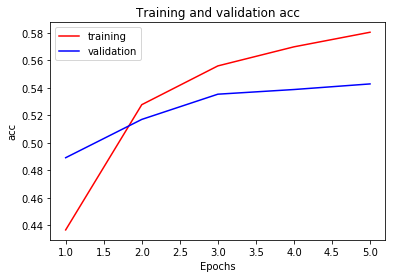

In [14]:
# Generate plots to assess the performance of the NN
ev.plot_learning_curve(history_dict = FNN_history_dict, metric = 'acc', set = 'train_valid')

In [27]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_FNN(model = FNN_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.6999213  0.07165194 0.22842672]
{'FutureSimple': 0.6999213, 'PastSimple': 0.07165194, 'PresentSimple': 0.22842672}


In [31]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_FNN(model = FNN_model, 
                                           data_test = tenses_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           generator = md.generator_df_FNN,
                                           use_multiprocessing = False, 
                                           num_threads = 0, 
                                           verbose = 0)

In [32]:
# True responses to compare the predictions to
y_test = tenses_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.5436666666666666

In [33]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.54905847 0.62079511 0.46336634]


## IV. Long short-term memory model <a ID="IV"></a> 

### Build a simple LSTM model

Build a simple LSTM that has 64 hidden units 

In [35]:
### Build a simple LSTM that has 64 hidden units 
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_neuron': 64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.2, 
    'optimizer': RMSprop, 
    'losses': categorical_crossentropy, 
    'last_activation': 'softmax'}

# Model fitting
LSTM_out, LSTM_model = md.train_LSTM(data_train = tenses_train, 
                                     data_valid = tenses_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     generator = md.generator_df_LSTM,
                                     shuffle = False, 
                                     use_cuda = False,
                                     use_multiprocessing = False, 
                                     num_threads = 0, 
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

Epoch 1/10
 - 59s - loss: 1.0584 - acc: 0.4178 - val_loss: 1.0095 - val_acc: 0.4656
Epoch 2/10
 - 63s - loss: 0.9963 - acc: 0.4820 - val_loss: 0.9931 - val_acc: 0.4890
Epoch 3/10
 - 56s - loss: 0.9796 - acc: 0.4964 - val_loss: 0.9849 - val_acc: 0.4977
Epoch 4/10
 - 52s - loss: 0.9682 - acc: 0.5102 - val_loss: 0.9806 - val_acc: 0.5020
Epoch 5/10
 - 64s - loss: 0.9599 - acc: 0.5236 - val_loss: 0.9780 - val_acc: 0.5050
Epoch 6/10
 - 63s - loss: 0.9533 - acc: 0.5310 - val_loss: 0.9767 - val_acc: 0.5060
Epoch 7/10
 - 56s - loss: 0.9477 - acc: 0.5387 - val_loss: 0.9742 - val_acc: 0.5120
Epoch 8/10
 - 61s - loss: 0.9396 - acc: 0.5461 - val_loss: 0.9698 - val_acc: 0.5191
Epoch 9/10
 - 56s - loss: 0.9300 - acc: 0.5551 - val_loss: 0.9631 - val_acc: 0.5261
Epoch 10/10
 - 58s - loss: 0.9205 - acc: 0.5645 - val_loss: 0.9583 - val_acc: 0.5344


In [36]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                528640    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 528,835
Trainable params: 528,835
Non-trainable params: 0
_________________________________________________________________


### Tune the parameters to find a good model

In [38]:
4*5*4*7*5*4*1*1

11200

In [39]:
### Parameter tuning using grid search 
p = {'epochs': [5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [16, 32, 64, 128, 256], # (x5)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, Nadam, RMSprop, SGD], # (x4)
     'losses': [categorical_crossentropy], # (x1)
     'last_activation': ['softmax'] # (x1)
     }
# => Total number of combinations: 4*5*4*7*5*4*1*1 = 11200

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/tenses/Results/grid_search_LSTM_tenses.csv'
md.grid_search_LSTM(data_train = tenses_train, 
                    data_valid = tenses_valid, 
                    cue_index = cue_to_index, 
                    outcome_index = outcome_to_index,
                    max_len = max_len,
                    generator = md.generator_df_LSTM,
                    params = p,
                    prop_grid = 5e-4, 
                    tuning_output_file = TUNING_PATH, 
                    shuffle = False, 
                    use_cuda = False,
                    use_multiprocessing = False, 
                    num_threads = 0, 
                    verbose = 0)

Iteration 1 out of 6: {'epochs': 20, 'batch_size': 128, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function categorical_crossentropy at 0x7f547dfad598>, 'last_activation': 'softmax'}

Iteration 2 out of 6: {'epochs': 5, 'batch_size': 128, 'hidden_neuron': 16, 'lr': 0.0002, 'dropout': 0.4, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f547dfad598>, 'last_activation': 'softmax'}

Iteration 3 out of 6: {'epochs': 10, 'batch_size': 64, 'hidden_neuron': 32, 'lr': 0.002, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f547dfad598>, 'last_activation': 'softmax'}

Iteration 4 out of 6: {'epochs': 30, 'batch_size': 32, 'hidden_neuron': 128, 'lr': 0.0002, 'dropout': 0.2, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function categorical_crossentropy at 0x7f547dfad598>, 'last_activation': 'softmax'

### Assessing the grid search using talos

In [40]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.5200407608695652
- Highest validation f1-score: 0.8497713364561399


In [41]:
# get the round with the best result
r.rounds2high(metric = 'val_acc')

0

In [42]:
# get the best paramaters
r.data.iloc[0,]

epochs                                                                20
batch_size                                                           128
hidden_neuron                                                        128
lr                                                                0.0002
dropout                                                              0.3
optimizer                                <class 'keras.optimizers.Adam'>
losses             <function categorical_crossentropy at 0x7f547dfad598>
last_activation                                                  softmax
loss                                                            0.824345
acc                                                             0.623162
precision                                                       0.701469
recall                                                          0.490809
f1score                                                         0.576874
val_loss                                           

### Retraining with the best parameters

In [10]:
### Hyperparameters to use
p = {'epochs': 20, # number of iterations on the full set 
    'batch_size': 128, 
    'hidden_neuron': 128, # number of neurons in the input layer 
    'lr': 0.0002, # learning rate       
    'dropout': 0.3, 
    'optimizer': Adam, 
    'losses': categorical_crossentropy, 
    'last_activation': 'softmax'}

# Model fitting
LSTM_out, LSTM_model = md.train_LSTM(data_train = tenses_train, 
                                     data_valid = tenses_valid, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     generator = md.generator_df_LSTM,
                                     shuffle = False, 
                                     use_cuda = False,
                                     use_multiprocessing = False, 
                                     num_threads = 0, 
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

Epoch 1/20
 - 33s - loss: 1.0516 - acc: 0.4251 - val_loss: 0.9868 - val_acc: 0.4885
Epoch 2/20
 - 29s - loss: 0.9698 - acc: 0.5013 - val_loss: 0.9765 - val_acc: 0.4935
Epoch 3/20
 - 30s - loss: 0.9496 - acc: 0.5191 - val_loss: 0.9787 - val_acc: 0.5020
Epoch 4/20
 - 29s - loss: 0.9402 - acc: 0.5287 - val_loss: 0.9810 - val_acc: 0.5068
Epoch 5/20
 - 28s - loss: 0.9332 - acc: 0.5376 - val_loss: 0.9835 - val_acc: 0.4986
Epoch 6/20
 - 30s - loss: 0.9244 - acc: 0.5489 - val_loss: 0.9825 - val_acc: 0.5000
Epoch 7/20
 - 33s - loss: 0.9059 - acc: 0.5629 - val_loss: 0.9696 - val_acc: 0.5265
Epoch 8/20
 - 29s - loss: 0.8848 - acc: 0.5826 - val_loss: 0.9722 - val_acc: 0.5340
Epoch 9/20
 - 28s - loss: 0.8720 - acc: 0.5926 - val_loss: 0.9761 - val_acc: 0.5312
Epoch 10/20
 - 29s - loss: 0.8642 - acc: 0.5964 - val_loss: 0.9808 - val_acc: 0.5296
Epoch 11/20
 - 27s - loss: 0.8579 - acc: 0.6017 - val_loss: 0.9850 - val_acc: 0.5279
Epoch 12/20
 - 28s - loss: 0.8528 - acc: 0.6034 - val_loss: 0.9870 - val_a

In [11]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_history_dict_tenses'
md.export_model(model = LSTM_model, path = MODEL_PATH)  # creates a HDF5 file 
md.export_history(history_dict = LSTM_out.history, path = HISTORY_PATH)
#del LSTM_model, LSTM_out  # deletes the existing model and history dictionary

In [14]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/LSTM_history_dict_tenses'
LSTM_model = md.import_model(MODEL_PATH)
LSTM_history_dict = md.import_history(path = HISTORY_PATH)

/home/adnane/anaconda3/envs/ooominds/lib/python3.7/site-packages/keras/engine/saving.py:251: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if weight_names:


### Evaluate the final model

/home/adnane/anaconda3/envs/ooominds/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


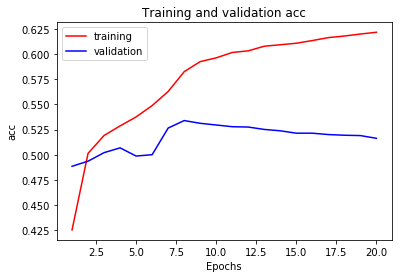

In [15]:
# Generate plots to assess the performance of the simple LSTM
ev.plot_learning_curve(history_dict = LSTM_history_dict, metric = 'acc', set = 'train_valid')

In [19]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_LSTM(model = LSTM_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index,
                                                   max_len = max_len)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.96527725 0.0043673  0.03035542]
{'FutureSimple': 0.96527725, 'PastSimple': 0.0043673012, 'PresentSimple': 0.030355424}


In [20]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_LSTM(model = LSTM_model, 
                                           data_test = tenses_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           max_len = max_len,  
                                           generator = md.generator_df_LSTM,
                                           use_multiprocessing = False, 
                                           num_threads = 0, 
                                           verbose = 0)

In [21]:
# True responses to compare the predictions to
y_test = tenses_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.5156666666666667

In [22]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.4925669  0.55351682 0.5019802 ]


## V. Naive discriminative learning model <a ID="V"></a> 

### Build a simple NDL model

In [23]:
### Build a simple NDL
p = {'epochs': 10, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_history_dict, NDL_model = md.train_NDL(data_train = tenses_train, 
                                           data_valid = tenses_valid,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           temp_dir = TEMP_DIR,
                                           chunksize = len(tenses_train),
                                           num_threads = 8, 
                                           verbose = 1,
                                           params = p)

Epoch 1/10
 - 56s - acc: 0.5170 - val_acc: 0.5047
Epoch 2/10
 - 59s - acc: 0.5375 - val_acc: 0.5131
Epoch 3/10
 - 58s - acc: 0.5480 - val_acc: 0.5255
Epoch 4/10
 - 59s - acc: 0.5571 - val_acc: 0.5315
Epoch 5/10
 - 58s - acc: 0.5613 - val_acc: 0.5332
Epoch 6/10
 - 56s - acc: 0.5667 - val_acc: 0.5322
Epoch 7/10
 - 63s - acc: 0.5715 - val_acc: 0.5301
Epoch 8/10
 - 56s - acc: 0.5751 - val_acc: 0.5311
Epoch 9/10
 - 57s - acc: 0.5771 - val_acc: 0.5311
Epoch 10/10
 - 58s - acc: 0.5794 - val_acc: 0.5338


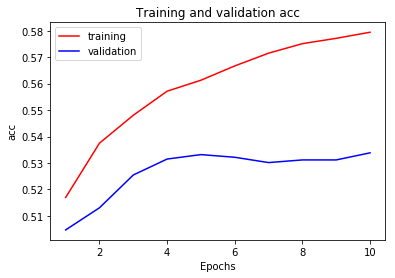

In [24]:
# Generate learning curve
ev.plot_learning_curve(history_dict = NDL_history_dict, metric = 'acc', set = 'train_valid')

### Tune the parameters to find a good model

In [27]:
### Parameter tuning using grid search 
p = {'lr': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], # learning rate (x8)
     'epochs': [4, 6, 8, 10], # number of iterations on the full set (x6)
     }
# => Total number of combinations: 8*4 = 32

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/tenses/Results/grid_search_NDL_tenses.csv'
md.grid_search_NDL(data_train = tenses_train, 
                   data_valid = tenses_valid, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index, 
                   temp_dir = TEMP_DIR,
                   chunksize = len(tenses_train),
                   params = p, 
                   prop_grid = 0.3, 
                   tuning_output_file = TUNING_PATH, 
                   num_threads = 8, 
                   verbose = 0)

Iteration 1 out of 10: {'lr': 0.01, 'epochs': 10}

Iteration 2 out of 10: {'lr': 0.01, 'epochs': 6}

Iteration 3 out of 10: {'lr': 0.05, 'epochs': 6}

Iteration 4 out of 10: {'lr': 1e-05, 'epochs': 8}

Iteration 5 out of 10: {'lr': 5e-05, 'epochs': 8}

Iteration 6 out of 10: {'lr': 1e-05, 'epochs': 6}

Iteration 7 out of 10: {'lr': 0.0005, 'epochs': 10}

Iteration 8 out of 10: {'lr': 0.0001, 'epochs': 6}

Iteration 9 out of 10: {'lr': 0.0005, 'epochs': 8}

Iteration 10 out of 10: {'lr': 0.001, 'epochs': 4}



### Assessing the grid search using talos

In [29]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.5348292029470864
- Highest validation f1-score: 0.5979828653883911


In [30]:
# get the round with the best result
r.rounds2high(metric = 'val_acc')

6

In [31]:
# get the best paramaters
r.data.iloc[6,]

lr                0.000500
epochs           10.000000
acc               0.561694
precision         0.560101
recall            0.561502
f1score           0.558981
val_acc           0.534829
val_precision     0.532567
val_recall        0.535657
val_f1score       0.531951
Name: 6, dtype: float64

### Retraining with the best parameters

In [32]:
### Hyperparameters to use
p = {'epochs': 10, # number of iterations on the full set 
    'lr': 0.0005}

# Model fitting
NDL_history_dict, NDL_model = md.train_NDL(data_train = tenses_train, 
                                           data_valid = tenses_valid,  
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           temp_dir = TEMP_DIR,
                                           chunksize = len(tenses_train),
                                           num_threads = 8, 
                                           verbose = 1,
                                           params = p)

Epoch 1/10
 - 58s - acc: 0.4984 - val_acc: 0.4906
Epoch 2/10
 - 60s - acc: 0.5164 - val_acc: 0.5037
Epoch 3/10
 - 57s - acc: 0.5286 - val_acc: 0.5134
Epoch 4/10
 - 58s - acc: 0.5367 - val_acc: 0.5161
Epoch 5/10
 - 62s - acc: 0.5442 - val_acc: 0.5201
Epoch 6/10
 - 58s - acc: 0.5486 - val_acc: 0.5248
Epoch 7/10
 - 56s - acc: 0.5534 - val_acc: 0.5308
Epoch 8/10
 - 56s - acc: 0.5568 - val_acc: 0.5332
Epoch 9/10
 - 58s - acc: 0.5593 - val_acc: 0.5335
Epoch 10/10
 - 62s - acc: 0.5617 - val_acc: 0.5348


In [17]:
# Save the weights and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_history_dict_tenses'
md.export_model(model = NDL_model, path = MODEL_PATH)  # create a HDF5 file 
md.export_history(history_dict = NDL_history_dict, path = HISTORY_PATH)
#del NDL_model, NDL_history_dict  # delete the existing model and history dictionary

In [12]:
# Load the model and training history
MODEL_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_tenses.h5'
HISTORY_PATH = TOP + 'illustrative_examples/tenses/Results/NDL_history_dict_tenses'
NDL_model = md.import_model(MODEL_PATH)
NDL_history_dict = md.import_history(path = HISTORY_PATH)

### Evaluate the final model

In [38]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_NDL(model = NDL_model, 
                                                   cue_seq = cue1_seq)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.42546887 0.25471278 0.31981835]
{'FutureSimple': 0.4254688695845501, 'PastSimple': 0.2547127780582049, 'PresentSimple': 0.31981835235724493}


The probability of future seems low, not because the model is unconfident, but because the softmax transformation used is 'soft' in terms of converting activations to probabilities. Decreasing the temperature parameter can emphasise more the predictions bewteen the three tense: 

In [39]:
# Test prediction for a single given cue sequence. Model expect input as array of shape (1, N_cues) 
cue1_seq = 'I_will_meet_you_tomorrow'
outcome1_prob_pred = ev.predict_proba_oneevent_NDL(model = NDL_model, 
                                                   cue_seq = cue1_seq,
                                                   T = 0.1)
print(outcome1_prob_pred) # vector of predicted probabilities
print({index_to_outcome[j+1]:outcome1_prob_pred[j] for j in range(len(outcome1_prob_pred))})

[0.94028754 0.0055602  0.05415226]
{'FutureSimple': 0.9402875417250711, 'PastSimple': 0.005560196158914734, 'PresentSimple': 0.05415226211601416}


In [40]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_NDL(model = NDL_model, 
                                           data_test = tenses_test, 
                                           temp_dir = TEMP_DIR,
                                           num_threads = 8)

In [41]:
# True responses to compare the predictions to
y_test = tenses_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.5316666666666666

In [42]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.5777998  0.56167176 0.45643564]
